In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
#import genetic_algorithm as ga #for pycharm module import

# 1 Initialization:
The initialization phase sets up the problem's constraints and parameters.

DISASSEMBLY_TIMES:
This dictionary provides the time taken by each manipulator to disassemble each part. There are two manipulators: M1 and M2. The nested dictionary provides the time taken by that manipulator to disassemble each part, where the key represents the part number and the value is the time taken.

For instance:

DISASSEMBLY_TIMES['M1'][1] is 2, meaning it takes 2 units of time for manipulator M1 to disassemble part 1.
DISASSEMBLY_TIMES['M2'][2] is 7, meaning it takes 7 units of time for manipulator M2 to disassemble part 2.

P (Precedence Constraints):
This dictionary defines the precedence relationship between parts. The key represents a part and the associated value (list) represents the parts that need to be disassembled before the key part.

For instance:

P[2] is [1], meaning part 1 should be disassembled before part 2.
P[3] is [1, 2], meaning parts 1 and 2 should be disassembled before part 3.
In simple words, you can't start disassembling part X until all the parts listed in P[X] are completely disassembled.

C (Concurrency Constraints):
This dictionary defines the concurrency constraints between parts. The key represents a part, and the associated value (list) represents the parts that cannot be disassembled concurrently (at the same time) with the key part.

For instance:

C[4] is [5], meaning parts 4 and 5 cannot be disassembled at the same time by the same or different manipulators.
C[6] is [7], meaning parts 6 and 7 cannot be disassembled at the same time by the same or different manipulators.
So if you start disassembling part 4, you cannot start disassembling part 5 until part 4 is completely disassembled and vice versa.



In [2]:
# Sample data
DISASSEMBLY_TIMES = {
    'M1': {1: 2, 2: 8, 3: 1, 4: 9, 5: 1, 6: 4, 7: 9, 8: 1, 9: 4, 10: 6},
    'M2': {1: 3, 2: 7, 3: 5, 4: 9, 5: 2, 6: 1, 7: 9, 8: 8, 9: 4, 10: 6}
}

In [3]:
P = {
    2: [1],      # part 1 should be disassembled before part 2
    3: [1, 2],   # parts 1 and 2 should be disassembled before part 3
    5: [4],      # part 4 should be disassembled before part 5
    7: [6],      # part 6 should be disassembled before part 7
    9: [8]       # part 8 should be disassembled before part 9
}

C = {
    4: [5],      # parts 4 and 5 cannot be disassembled at the same time
    6: [7]       # parts 6 and 7 cannot be disassembled at the same time
}

v1 and v2 are a double-vector list structure adopted as the encoding form represents the disassembly parts/tasks sequence in which each element corresponds to one part or task.

In [4]:
def depth_first_traversal(part, precedence_matrix, visited):
    # Base case: if the part is already visited, return
    if visited[part]:
        return []
    sequence = [part]
    visited[part] = True
    for i, val in enumerate(precedence_matrix[part]):
        if val == 1:
            sequence += depth_first_traversal(i, precedence_matrix, visited)
    return sequence

def initialize_solution_v2(precedence_matrix, num_manipulators):
    visited = [False for _ in range(precedence_matrix.shape[0])]
    v1 = []
    for i in range(precedence_matrix.shape[0]):
        v1 += depth_first_traversal(i, precedence_matrix, visited)
    v1 = [x+1 for x in v1]  # Since parts are 1-indexed
    v2 = np.random.randint(1, num_manipulators + 1, size=len(v1)).tolist()
    return v1, v2
# Convert P to matrix form
def convert_to_matrix(P, total_parts=10):
    matrix = np.zeros((total_parts, total_parts))
    for part, predecessors in P.items():
        for pre in predecessors:
            matrix[part-1][pre-1] = 1
    return matrix

# Your precedence constraints
P = {
    2: [1],
    3: [1, 2],
    5: [4],
    7: [6],
    9: [8]
}

# Convert P to matrix form and print
precedence_matrix = convert_to_matrix(P)
print(precedence_matrix)

# Now call the initialize_solution_v2 function
v1, v2 = initialize_solution_v2(precedence_matrix, 2)
print("v1:", v1)
print("v2:", v2)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
v1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
v2: [1, 2, 1, 1, 1, 1, 2, 2, 1, 2]


## Understanding matrix
* The first row is all zeroes, which indicates part 1 doesn't have any predecessor.
* The second row starts with a 1, which indicates that part 1 must be disassembled before part 2.
* The third row has its first two entries as 1, which means parts 1 and 2 must be disassembled before part 3.
... and so on.

# 2. Evaluation Function:
The evaluation function, or fitness function, is the heart of any genetic algorithm. It quantifies how fit a potential solution (chromosome) is concerning the problem. For this scenario, the fitness is determined by the total disassembly time. Lower disassembly times indicate better fitness, and hence the goal is to minimize this value. The function takes into account the precedence and conflict constraints to ensure feasible solutions.

In [5]:
def evaluate_chromosome(chromosome):
    v1, v2 = chromosome
    total_disassembly_time = 0
    CT = {}

    for i, part in enumerate(v1):
        manipulator = v2[i]

        # Calculate start time (STi)
        AND_predecessors = P.get(part, [])
        same_manipulator_predecessors = [p for idx, p in enumerate(v1) if idx < i and v2[idx] == manipulator]
        conflicting_parts = C.get(part, [])

        max_completion_time = max_completion_time = max([CT.get(p, 0) for p in AND_predecessors + same_manipulator_predecessors + conflicting_parts], default=0)


        DTi = DISASSEMBLY_TIMES[f"M{manipulator}"][part]
        CT[part] = max_completion_time + DTi
        total_disassembly_time = max(total_disassembly_time, CT[part])

    return total_disassembly_time


# 3. Selection:

Selection is the process of choosing parents that will mate to produce the next generation. The second method outperform the first so the routnament selection method is used.

* Roulette Wheel Selection: This probabilistic selection method gives every individual a chance of being selected based on its fitness. Individuals with better fitness have higher chances but do not guarantee selection.

* Tournament Selection: A set number of individuals are chosen at random, and the one with the best fitness among them is selected. This method strikes a balance between exploration (searching new areas of the solution space) and exploitation (choosing the best solutions).

In [6]:
'''def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    selection_probs = [f / total_fitness for f in fitness_values]
    r = random.random()
    for i, prob in enumerate(selection_probs):
        r -= prob
        if r <= 0:
            return population[i]'''
def tournament_selection(population, fitness_values, tournament_size=3):
    """
    Perform tournament selection.
    
    Args:
    - population: The entire population.
    - fitness_values: List of fitness values corresponding to each individual in the population.
    - tournament_size: Number of individuals participating in each tournament.default 3
    
    Returns:
    - selected_individual: The winner of the tournament.
    """
    
    # Randomly select 'tournament_size' individuals
    tournament_individuals = random.sample(list(zip(population, fitness_values)), tournament_size)
    
    # Sort them by their fitness. Depending on your problem, this could be a min or max sort.
    # Here, I'm assuming a minimization problem based on your fitness computation. 
    # If it's a maximization problem, reverse the sorting.
    tournament_individuals.sort(key=lambda x: x[1])
    
    # Return the best individual from the tournament
    selected_individual = tournament_individuals[0][0]
    return selected_individual


# 4. Crossover:
Crossover, or recombination, mimics biological reproduction where two parents combine genes to produce offspring. The implemented crossover ensures precedence constraints are maintained, vital for the feasibility of solutions. Two strings, a1 and a2, are generated to assist in this. The crossover is performed based on these strings ensuring that the offspring maintains the precedence order of the parent chromosomes.

In [7]:
def generate_a1_a2_strings(chromosome):
    v1 = chromosome[0]
    a1 = [len(P.get(part, [])) for part in v1]  # Number of predecessors for each part
    a2 = [i - sum([1 for p in P.get(part, []) if p in v1[:i]]) for i, part in enumerate(v1)]
    return a1, a2

def precedence_preservative_crossover(parent1, parent2):
    v1_1, v2_1 = parent1
    v1_2, v2_2 = parent2
    
    a1_1, a2_1 = generate_a1_a2_strings(parent1)
    a1_2, a2_2 = generate_a1_a2_strings(parent2)
    
    point = random.randint(1, len(v1_1) - 1)  # Crossover point
    offspring1_v1 = v1_1[:point] + [part for part in v1_2 if part not in v1_1[:point]]
    offspring2_v1 = v1_2[:point] + [part for part in v1_1 if part not in v1_2[:point]]
    
    # Crossover for v2 based on the a1 and a2 values
    offspring1_v2 = []
    offspring2_v2 = []
    for i in range(len(v2_1)):
        if a1_1[i] < a1_2[i] or (a1_1[i] == a1_2[i] and a2_1[i] <= a2_2[i]):
            offspring1_v2.append(v2_1[i])
            offspring2_v2.append(v2_2[i])
        else:
            offspring1_v2.append(v2_2[i])
            offspring2_v2.append(v2_1[i])
    
    offspring1 = (offspring1_v1, offspring1_v2)
    offspring2 = (offspring2_v1, offspring2_v2)
    
    return offspring1, offspring2


# 5. Mutation:
Mutation introduces genetic diversity by making small changes in a chromosome. In our scenario, mutation swaps two manipulator assignments without violating the precedence constraints. Such alterations ensure exploration of the solution space, preventing the algorithm from getting stuck in local minima.

In [8]:
def mutate_based_on_precedence(chromosome):
    v1, v2 = chromosome[:]
    valid_indices = [i for i, part in enumerate(v1) if not P.get(part)]
    
    if len(valid_indices) < 2:
        return chromosome  # No mutation possible without breaking precedence
    
    idx1, idx2 = random.sample(valid_indices, 2)
    v2[idx1], v2[idx2] = v2[idx2], v2[idx1]
    return v1, v2



# 6. Genetic Algorithm Implementation:
This section will bring everything together, explaining the overall flow of the genetic algorithm and showcasing the dynamic mutation rate adjustment.

In [9]:
# GA parameters
MaxIte = 50
PopSize = 200
pc = 0.70 #crossover probability
pm = 0.05 #mutation probability
elitism_factor = 0.00  # Percentage of best individuals to carry forward {every generation 1/100 elites remains unchanged)


def improved_GA():
    population = [(random.sample(range(1, 11), 10), [random.randint(1, 2) for _ in range(10)]) for _ in range(PopSize)]
    fitness_values = [1 / evaluate_chromosome(ch) for ch in population]
    best_chromosome = min(population, key=evaluate_chromosome)
    previous_best_fitness = 1 / evaluate_chromosome(best_chromosome)
    
    # Dynamic mutation rate
    stagnant_generations = 0
    dynamic_pm = pm

    # Elitism: select top x% of the population to carry forward
    num_elites = int(elitism_factor * PopSize)
    
    best_fitness_values = []
    avg_fitness_values = []
    worst_fitness_values = []
    
    iteration = 0
    while iteration < MaxIte:
        new_population = population[:num_elites]  # Start with elites
        
        while len(new_population) < PopSize:
            parent1 = tournament_selection(population, fitness_values, tournament_size=3)
            
            if random.random() < pc:
                parent2 = tournament_selection(population, fitness_values, tournament_size=3)
                while parent2 == parent1:  # Ensure we select two different parents
                    parent2 = tournament_selection(population, fitness_values, tournament_size=3)
                offspring1, offspring2 = precedence_preservative_crossover(parent1, parent2)
                new_population.extend([offspring1, offspring2])

            if random.random() < dynamic_pm and len(new_population) < PopSize:
                mutated_chromosome = mutate_based_on_precedence(parent1)
                new_population.append(mutated_chromosome)

        population = new_population
        fitness_values = [1 / evaluate_chromosome(ch) for ch in population]
        current_best = min(population, key=evaluate_chromosome)
        current_best_fitness = 1 / evaluate_chromosome(current_best)

        best_fitness_values.append(current_best_fitness)
        avg_fitness_values.append(sum(fitness_values) / len(fitness_values))
        worst_fitness_values.append(1 / max([evaluate_chromosome(ch) for ch in population]))
        
        # Adjust mutation rate if fitness is stagnant
        if current_best_fitness <= previous_best_fitness:
            stagnant_generations += 1
        else:
            stagnant_generations = 0
        
        if stagnant_generations >= 5:  # Threshold of 5 generations of stagnant fitness
            dynamic_pm *= 1.05  # Increase mutation rate by 5%
            if dynamic_pm > 1:
                dynamic_pm = 1
            stagnant_generations = 0

        # Print the best solution for the current iteration
        print(f"Iteration {iteration+1}: Best Solution = {current_best} with fitness = {current_best_fitness}")

        previous_best_fitness = current_best_fitness
        iteration += 1

    return min(population, key=evaluate_chromosome), best_fitness_values, avg_fitness_values, worst_fitness_values

best_solution, best_fitness_values, avg_fitness_values, worst_fitness_values = improved_GA()


Iteration 1: Best Solution = ([7, 3, 9, 8, 10, 4, 6, 1, 5, 2], [1, 1, 2, 1, 2, 2, 2, 1, 2, 1]) with fitness = 0.045454545454545456
Iteration 2: Best Solution = ([3, 8, 4, 6, 9, 2, 10, 5, 7, 1], [1, 1, 2, 2, 2, 2, 1, 2, 1, 1]) with fitness = 0.043478260869565216
Iteration 3: Best Solution = ([9, 7, 1, 4, 8, 5, 10, 3, 6, 2], [1, 2, 2, 1, 1, 2, 2, 1, 2, 1]) with fitness = 0.043478260869565216
Iteration 4: Best Solution = ([6, 3, 2, 5, 7, 8, 10, 9, 4, 1], [2, 1, 1, 2, 2, 1, 2, 2, 1, 2]) with fitness = 0.04
Iteration 5: Best Solution = ([3, 6, 7, 5, 2, 8, 9, 4, 1, 10], [1, 2, 2, 2, 2, 1, 2, 2, 2, 1]) with fitness = 0.02857142857142857
Iteration 6: Best Solution = ([7, 3, 6, 9, 10, 4, 2, 5, 1, 8], [2, 2, 2, 2, 2, 1, 2, 2, 2, 1]) with fitness = 0.02702702702702703
Iteration 7: Best Solution = ([9, 1, 10, 2, 7, 6, 8, 4, 3, 5], [2, 2, 2, 2, 2, 2, 2, 1, 1, 1]) with fitness = 0.02631578947368421
Iteration 8: Best Solution = ([2, 8, 5, 1, 9, 10, 6, 3, 4, 7], [2, 2, 2, 2, 2, 2, 2, 2, 2, 1]) with fi

The order in which these parts are disassembled and the manipulator assigned ensures that all precedence constraints are respected and aims to minimize the total disassembly time based on the genetic algorithm's evaluation.

Iteration 1: Best Solution = ([4, 2, 6, 9, 8, 10, 7, 3, 1, 5], [2, 2, 1, 1, 1, 2, 1, 1, 1, 1]) with fitness = 0.045454545454545456
Iteration 2: Best Solution = ([7, 1, 3, 6, 9, 2, 5, 4, 10, 8], [2, 2, 2, 2, 1, 2, 1, 1, 1, 1]) with fitness = 0.04
Iteration 3: Best Solution = ([6, 9, 4, 7, 2, 8, 10, 5, 3, 1], [2, 1, 2, 1, 2, 1, 1, 1, 2, 2]) with fitness = 0.04
Iteration 4: Best Solution = ([7, 10, 4, 5, 6, 9, 2, 1, 3, 8], [1, 2, 2, 2, 2, 1, 1, 1, 1, 2]) with fitness = 0.038461538461538464
Iteration 5: Best Solution = ([10, 2, 3, 6, 1, 7, 9, 5, 8, 4], [1, 1, 1, 2, 2, 1, 2, 2, 2, 2]) with fitness = 0.037037037037037035
Iteration 6: Best Solution = ([9, 7, 2, 10, 1, 3, 6, 5, 8, 4], [1, 1, 2, 2, 2, 2, 2, 2, 2, 2]) with fitness = 0.024390243902439025
Iteration 7: Best Solution = ([2, 7, 9, 3, 5, 4, 1, 6, 8, 10], [1, 1, 2, 2, 2, 2, 2, 2, 2, 2]) with fitness = 0.023809523809523808
Iteration 8: Best Solution = ([2, 6, 4, 9, 10, 1, 5, 3, 7, 8], [1, 1, 2, 2, 2, 2, 2, 2, 2, 2]) with fitness = 0.021

<Figure size 1200x600 with 0 Axes>

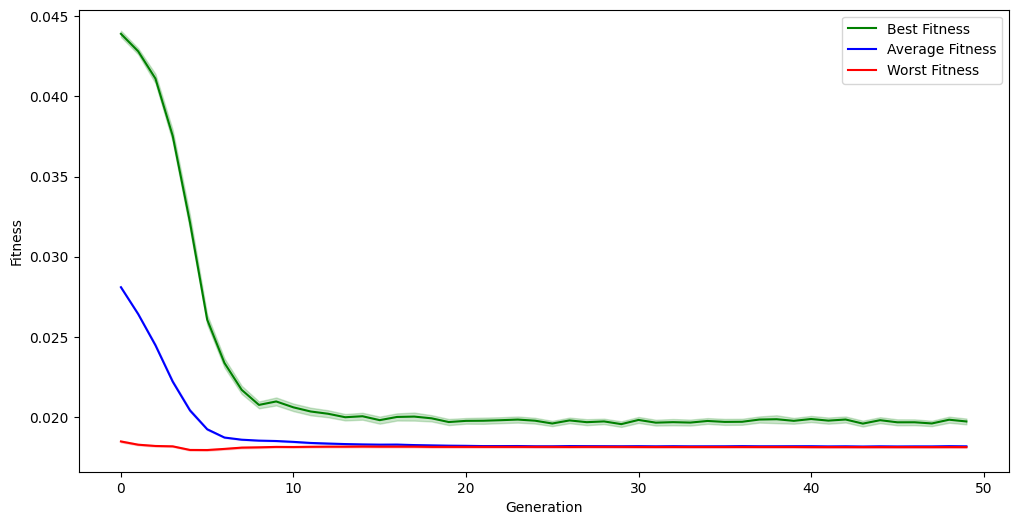

Best Solution Among 50 Iterations: ([10, 6, 7, 5, 8, 2, 1, 4, 3, 9], [1, 2, 2, 2, 2, 2, 2, 1, 2, 2]) with fitness: 39


In [10]:
# Lists to store the best, average, and worst fitness values for each of the 100 runs
all_best_fitness_values = []
all_avg_fitness_values = []
all_worst_fitness_values = []

best_global_solution = None
best_global_fitness = float('inf')

for _ in range(50):
    best_solution, best_fitness_values, avg_fitness_values, worst_fitness_values = improved_GA()
    current_fitness = evaluate_chromosome(best_solution)
    
    all_best_fitness_values.append(best_fitness_values)
    all_avg_fitness_values.append(avg_fitness_values)
    all_worst_fitness_values.append(worst_fitness_values)
    
    if current_fitness < best_global_fitness:
        best_global_solution = best_solution
        best_global_fitness = current_fitness

# Plotting the fitness values
plt.figure(figsize=(12, 6))

# Average values over 100 runs
avg_best = [sum(x)/len(x) for x in zip(*all_best_fitness_values)]
avg_avg = [sum(x)/len(x) for x in zip(*all_avg_fitness_values)]
avg_worst = [sum(x)/len(x) for x in zip(*all_worst_fitness_values)]

# Calculate standard errors for each generation
se_best = [np.std(x)/np.sqrt(100) for x in zip(*all_best_fitness_values)]
se_avg = [np.std(x)/np.sqrt(100) for x in zip(*all_avg_fitness_values)]
se_worst = [np.std(x)/np.sqrt(100) for x in zip(*all_worst_fitness_values)]

# Calculate the bounds for shading
upper_best = [avg + se for avg, se in zip(avg_best, se_best)]
lower_best = [avg - se for avg, se in zip(avg_best, se_best)]

upper_avg = [avg + se for avg, se in zip(avg_avg, se_avg)]
lower_avg = [avg - se for avg, se in zip(avg_avg, se_avg)]

upper_worst = [avg + se for avg, se in zip(avg_worst, se_worst)]
lower_worst = [avg - se for avg, se in zip(avg_worst, se_worst)]

# Plotting
plt.figure(figsize=(12, 6))

# Best Fitness
plt.plot(avg_best, label='Best Fitness', color='green')
plt.fill_between(range(len(avg_best)), lower_best, upper_best, color='green', alpha=0.2)

# Average Fitness
plt.plot(avg_avg, label='Average Fitness', color='blue')
plt.fill_between(range(len(avg_avg)), lower_avg, upper_avg, color='blue', alpha=0.2)

# Worst Fitness
plt.plot(avg_worst, label='Worst Fitness', color='red')
plt.fill_between(range(len(avg_worst)), lower_worst, upper_worst, color='red', alpha=0.2)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

print("Best Solution Among 50 Iterations:", best_global_solution, "with fitness:", best_global_fitness)

* The fitness values displayed on the graph are in decimal form because they are reciprocals of the disassembly time, used to convert the problem into a maximization context.
* The value "with fitness:" represents the total disassembly time (not the fitness) for the best solution found across all iterations.

## In the above graph 

* The green line represents the "Best Fitness."
* The blue line represents the "Average Fitness."
* The red line represents the "Worst Fitness."

#### The "Best Fitness" line (green) starts at a high value and gradually decreases, implying that the best solutions are being found as the algorithm progresses.
#### The "Worst Fitness" line (red) remains relatively steady at a lower value, suggesting that the least optimal solutions have a consistent fitness value.